In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({'font.size': 8})

In [ ]:
g_v = 5
theta = -3 * np.pi / 4
vel = g_v * np.array([np.cos(theta), np.sin(theta)])
radius_dot_f = lambda x, t: 0
radius_f = lambda x, t: 10 + radius_dot_f(x, t) * t
beta = .1
speed = 10
print(f'k > {2 / np.pi * speed *np.arctan(beta) ** 2}')
g = lambda x, t: np.array([vel[0]  * t, vel[1] * t])
r = lambda x, t: np.sqrt((x[0] - g(x, t)[0]) ** 2 + (x[1]- g(x, t)[1]) ** 2)
a1 = lambda x, t: np.arctan((r(x, t) - radius_f(x, t)) * beta)
e_r = lambda x, t: np.array([(x[0] - g(x, t)[0]), (x[1] - g(x, t)[1])]) / r(x, t)
e_theta = lambda x, t: np.array([-x[1] + g(x, t)[1], x[0] - g(x, t)[0]]) / r(x, t)

V = lambda x, t: a1(x, t) ** 2 / 2
Minv = lambda x, t: (1 + (r(x, t) - radius_f(x, t)) ** 2) * np.array([[x[0] - g(x, t)[0], -(x[1] - g(x, t)[1])], [(x[1] - g(x, t)[1]), x[0] - vel[0] * t]]) / (r(x, t))
grad = lambda x, t: np.array([a1(x, t) * (x[0] - g(x,t)[0]), a1(x, t) * (x[1] - g(x, t)[1])]) / r(x, t)
wedge = lambda x, t: np.array([-x[1] + g(x, t)[1], x[0] - g(x, t)[0]]) / (r(x, t) * (1 + (r(x, t) - radius_f(x, t)) ** 2))
da1dt = lambda x, t: -(radius_dot_f(x, t) + np.dot(vel, e_r(x, t))) / (1 + (r(x, t) - radius_f(x, t)) ** 2)
a = lambda x, t: np.array([da1dt(x, t), 0])

G = lambda x, t: (speed - (1 + (r(x, t) - radius_f(x, t)) ** 2 ) * da1dt(x, t)) * 2 / np.pi if V(x, t) != 0 else 0
H = lambda x, t: np.sqrt(speed ** 2 - (-da1dt(x, t) - G(x, t) * np.arctan((r(x, t) - radius_f(x, t)) * beta)) ** 2)


def u(x, t):
    radius = radius_f(x, t)
    radius_dot = radius_dot_f(x, t)
    g = np.array([vel[0]  * t, vel[1] * t])
    r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
    e_r = np.array([(x[0] - g[0]), (x[1] - g[1])]) / r
    e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r

    G = (speed - g_v + np.abs(radius_dot)) * 2 / np.pi * np.arctan(beta * (r - radius))
    H = np.sqrt(speed ** 2 - (-G + np.dot(vel, e_r) + radius_dot) ** 2)

    ctrl = (-G + np.dot(vel, e_r) + radius_dot) * e_r + H * e_theta
    return ctrl


def dot_phi(x, t):
    radius = radius_f(x, t)
    radius_dot = radius_dot_f(x, t)
    g = np.array([vel[0]  * t, vel[1] * t])
    r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
    e_r = np.array([(x[0] - g[0]), (x[1] - g[1])]) / r
    e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
    u_theta = np.dot(e_theta, u(x, t))
    return  -4 / np.pi ** 2 * beta * np.arctan(beta * (r - radius)) * ((speed - g_v - np.abs(radius_dot)) ** 2) / (1 + beta ** 2 * (r - radius) ** 2)

def psi_dot(x, t):
    radius = radius_f(x, t)
    radius_dot = radius_dot_f(x, t)
    g = np.array([vel[0]  * t, vel[1] * t])
    r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
    e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
    u_theta = np.dot(e_theta, u(x, t))
    theta_dot = u_theta / r - np.dot(vel, e_theta) / r
    dot_phi_p = -4 / np.pi ** 2 * beta * np.arctan(beta * (r - radius)) * ((speed - g_v - np.abs(radius_dot)) ** 2) / (1 + beta ** 2 * (r - radius) ** 2)
    return dot_phi_p / u_theta + r * theta_dot ** 2 / (u_theta)

def invert(x, t):
    g = np.array([vel[0]  * t, vel[1] * t])
    radius = radius_f(x, t)
    radius_dot = radius_dot_f(x, t)
    r = np.sqrt((x[0] - g[0]) ** 2 + (x[1]- g[1]) ** 2)
    e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
    e_r = np.array([x[0] - g[1], x[1] - g[1]]) / r
    u_theta = np.dot(e_theta, u(x, t))
    
    theta = np.arctan2(u(x, t)[1], u(x, t)[0])
    psi = x[2]
    psi_d = (theta - psi + np.pi) % (2 * np.pi) - np.pi
    a = (np.dot(g, e_r) + radius_dot) * (1 - np.cos(-psi_d))/(-psi_d)
    b = u_theta * np.sin(-psi_d) / -psi_d
    c = (beta * 2 / np.pi * np.arctan(beta * (r - radius)) / (1 + beta ** 2 * (r - radius)))
    return -(a + b) * c
        

k > 0.06324079143776297


/tmp/ipykernel_12363/3855226504.py:57: RuntimeWarning: invalid value encountered in divide
  e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
/tmp/ipykernel_12363/3855226504.py:31: RuntimeWarning: invalid value encountered in divide
  e_r = np.array([(x[0] - g[0]), (x[1] - g[1])]) / r
/tmp/ipykernel_12363/3855226504.py:32: RuntimeWarning: invalid value encountered in divide
  e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r


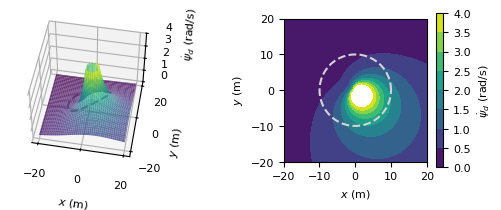

In [3]:
n = 401
x, y = np.meshgrid(np.linspace(-20, 20, n), np.linspace(-20, 20, n))
X = np.stack([x, y])
zz = np.zeros([n, n])
r = 10
theta = np.linspace(0, 2 * np.pi)
circle = np.array([r * np.cos(theta), r * np.sin(theta)]).T

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        zz[i, j] = psi_dot(X[:, i, j], 0)

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(121, projection='3d')
zz[zz> 4] = np.nan
ax.view_init(50, -80, 0)
ax.plot_surface(x, y, zz, cmap='viridis', lw=0, alpha=.8)
ax.set_zlim([0, 4])
ax.plot3D(circle[:, 0], circle[:, 1], [psi_dot(circle[i, :], 0) for i in range(circle.shape[0])], color='gray', ls='--')
ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
ax.set_zlabel(r'$\dot{\psi}_d$ (rad/s)')

ax = fig.add_subplot(122)
map = ax.contourf(x, y, zz, cmap='viridis')
ax.contour(x, y, zz, [0], colors=['k'])
theta = np.linspace(0, 2 * np.pi)
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')
ax.set_aspect('equal', 'box')
cbar = fig.colorbar(map)
r = 10
ax.plot(r * np.cos(theta), r * np.sin(theta), color='lightgray', ls='--')
plt.subplots_adjust(wspace=.6)
cbar.set_label(r'$\dot{\psi}_d$ (rad/s)')
fig.savefig('figures/feedforward_arctan.pdf', bbox_inches='tight')

/tmp/ipykernel_12363/3855226504.py:31: RuntimeWarning: invalid value encountered in divide
  e_r = np.array([(x[0] - g[0]), (x[1] - g[1])]) / r
/tmp/ipykernel_12363/3855226504.py:32: RuntimeWarning: invalid value encountered in divide
  e_theta = np.array([-x[1] + g[1], x[0] - g[0]]) / r
/tmp/ipykernel_12363/1994242091.py:7: RuntimeWarning: invalid value encountered in divide
  e_theta = lambda x, t: np.array([-x[1] + g(x, t)[1], x[0] - g(x, t)[0]]) / r(x, t)
/tmp/ipykernel_12363/1994242091.py:8: RuntimeWarning: invalid value encountered in divide
  e_r = lambda x, t: np.array([(x[0] - g(x, t)[0]), (x[1] - g(x, t)[1])]) / r(x, t)


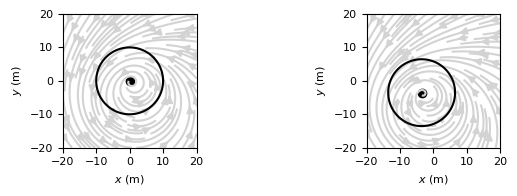

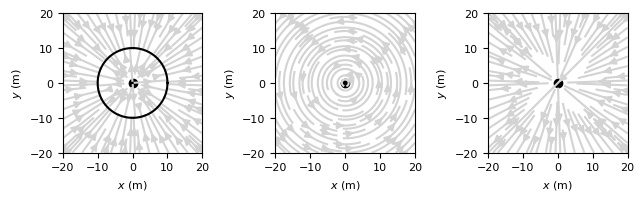

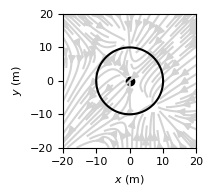

In [ ]:
n = 201
x, y = np.meshgrid(np.linspace(-20, 20, n), np.linspace(-20, 20, n))
theta = np.linspace(0, 2 * np.pi, 100)

r = lambda x, t: np.sqrt((x[0] - g(x, t)[0]) ** 2 + (x[1]- g(x, t)[1]) ** 2)
g = lambda x, t: np.array([vel[0]  * t, vel[1] * t])
e_theta = lambda x, t: np.array([-x[1] + g(x, t)[1], x[0] - g(x, t)[0]]) / r(x, t)
e_r = lambda x, t: np.array([(x[0] - g(x, t)[0]), (x[1] - g(x, t)[1])]) / r(x, t)




X = np.stack([x, y])
vector = np.zeros_like(X)
spin = np.zeros_like(X)
attract = np.zeros_like(X)
flow = np.zeros_like(X)
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        vector[:,i, j] = u(X[:, i, j], 0)
        spin[:, i, j] = np.dot(u(X[:, i, j], 0), e_theta(X[:, i, j], 0)) * e_theta(X[:, i, j], 0)
        attract[:, i, j] = (np.dot(u(X[:, i, j], 0), e_r(X[:, i, j], 0)) - np.dot(vel, e_r(X[:, i, j], 0)) - radius_dot_f(X[:, i, j], 0)) * e_r(X[:, i, j], 0)
        flow[:, i, j] = (np.dot(vel, e_r(X[:, i, j], 0)) + radius_dot_f(X[:, i, j], 0)) * e_r(X[:, i, j], 0)
fig = plt.figure(figsize=(6.5, 2))
axes = fig.subplots(1, 2)
ax = axes[0]
ax.streamplot(X[0, :, :], X[1, :, :], vector[0, :, :], vector[1, :, :], color='lightgray')
ax.plot(10 * np.cos(theta), 10 * np.sin(theta), color='k')
ax.scatter([0], [0], color='k')
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        vector[:,i, j] = u(X[:, i, j], 1)
ax.set_aspect('equal', 'box')
ax = axes[1]
ax.streamplot(X[0, :, :], X[1, :, :], vector[0, :, :], vector[1, :, :], color='lightgray')
ax.plot(10 * np.cos(theta) + vel[0] * 1, 10 * np.sin(theta) + vel[1] * 1, color='k')
ax.scatter([vel[0] * 1], [vel[1] * 1], color='k')
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')
ax.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig('figures/field_timevarying_arctan.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(6.5, 2))
axes = fig.subplots(1, 3)
axes[0].streamplot(X[0, :, :], X[1, :, :], attract[0, :, :], attract[1, :, :], color='lightgray')
axes[0].plot(10 * np.cos(theta), 10 * np.sin(theta), color='k')
axes[0].scatter([0], [0], color='k')
axes[0].set_xlabel(r'$x$ (m)')
axes[0].set_ylabel(r'$y$ (m)')
axes[0].set_aspect('equal', 'box')
axes[1].streamplot(X[0, :, :], X[1, :, :], spin[0, :, :], spin[1, :, :], color='lightgray')
axes[1].scatter([0], [0], color='k')
axes[1].set_xlabel(r'$x$ (m)')
axes[1].set_ylabel(r'$y$ (m)')
axes[1].set_aspect('equal', 'box')
axes[2].streamplot(X[0, :, :], X[1, :, :], flow[0, :, :], flow[1, :, :], color='lightgray')
axes[2].scatter([0], [0], color='k')
axes[2].set_xlabel(r'$x$ (m)')
axes[2].set_ylabel(r'$y$ (m)')
axes[2].set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig('figures/three_fields_arctan.pdf')


fig = plt.figure(figsize=(3, 2))
axes = fig.subplots(1, 1)
axes.streamplot(X[0, :, :], X[1, :, :], attract[0, :, :] + flow[0, :, :], attract[1, :, :] + flow[0, :, :], color='lightgray')
axes.plot(10 * np.cos(theta), 10 * np.sin(theta), color='k')
axes.scatter([0], [0], color='k')
axes.set_xlabel(r'$x$ (m)')
axes.set_ylabel(r'$y$ (m)')
axes.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig('figures/flow_attract.pdf', bbox_inches='tight')

(-1.0, 1.0)

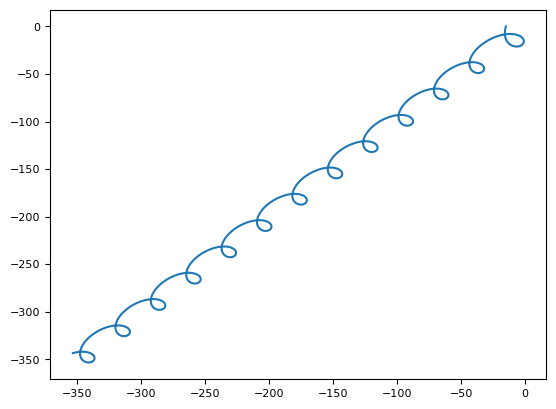

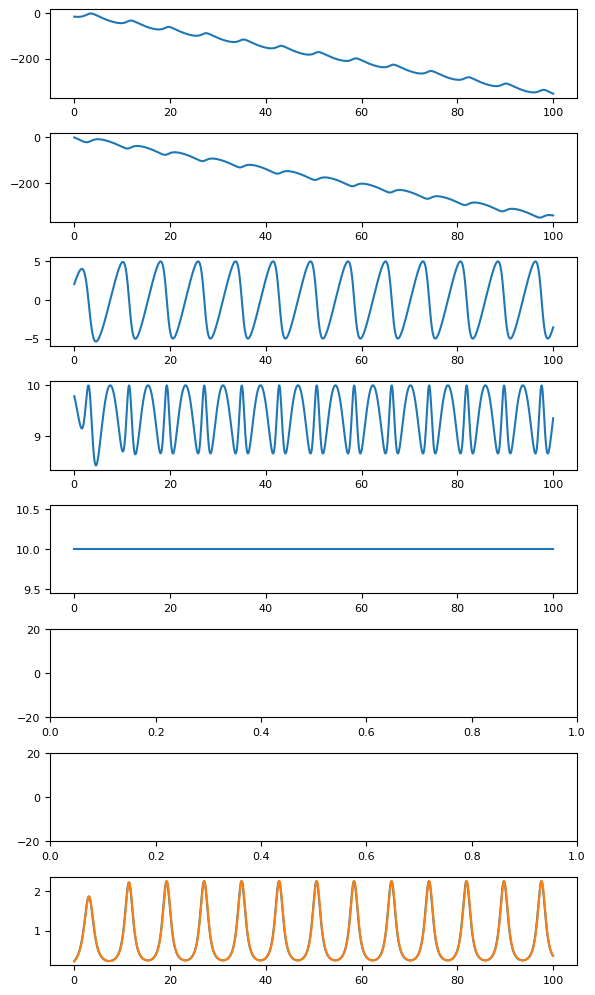

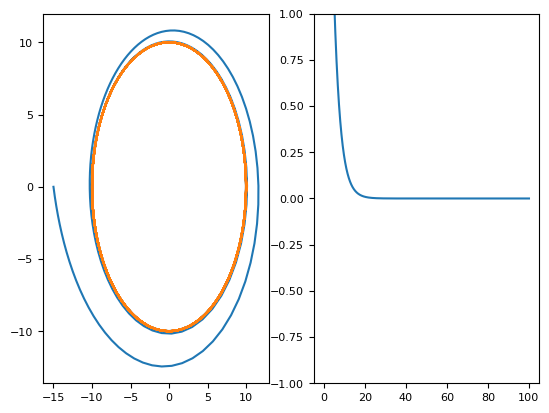

In [ ]:
def sys(t, x):
    xy =  u(x, t)
    theta = np.arctan2(xy[1], xy[0])
    return np.array([
        speed * np.cos(theta),
        speed * np.sin(theta)
    ])

class Results:
    def __init__(self, t, y):
        self.t = t
        self.y = y
dt = .001
t0 = 0
tf = 100
t_span = np.arange(t0, tf, dt)
x = [-15, 0]
y = [x]
# for t in t_span:
#     x = x + sys(t, x) * dt
#     y.append(x)
# res = Results(t_span, np.array(y[:-1]).T)
res = solve_ivp(sys, [t0, tf], x, max_step=.1)

def angleDiff(a, b):
    c = a - b
    c = (c + np.pi) % (2 * np.pi) - np.pi
    return c

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(res.y[0, :], res.y[1, :])

fig = plt.figure(figsize=(6, 10))
axes = fig.subplots(6)
axes[0].plot(res.t, res.y[0, :])
axes[1].plot(res.t, res.y[1, :])
dx = np.array([sys(t, x) for t, x in zip(res.t, res.y.T)])

v_loc = np.array([g([0, 0], t) for t in res.t])
dist = res.y - v_loc.T 
r = np.linalg.norm(dist, axis=0)
e_theta = np.column_stack([-dist[1]  / r , dist[0]  / r ])
e_r = (dist / r).T
u_theta = np.einsum('ij, ij -> i', dx, e_theta)
u_r = np.einsum('ij,ij->i', dx, e_r)
psi = np.arctan2(dx[:, 1], dx[:, 0])
dphi = np.array([dot_phi(x, t) for x, t in zip(res.y.T, res.t)]) 
axes[2].plot(res.t, u_r)
axes[3].plot(res.t, u_theta)
axes[4].plot(res.t, np.linalg.norm(dx, axis=1))

psi_dot_v = angleDiff(psi[1:], psi[:-1]) / (res.t[1:] - res.t[:-1])
axes[5].plot(res.t[:-1], psi_dot_v)
axes[5].plot(res.t, [psi_dot(x, t) for x, t in zip(res.y.T, res.t)])
fig.tight_layout()

fig = plt.figure()
axes = fig.subplots(1, 2)
axes[0].plot(dist[0, :], dist[1, :])
theta = np.arctan2(dist[1, :], dist[0, :])
axes[0].plot(10 * np.cos(theta), 10 * np.sin(theta))
axes[1].plot(res.t, np.linalg.norm(dist - 10 * np.array([np.cos(theta), np.sin(theta)]), axis=0))
axes[1].set_ylim([-1, 1])

k > 2.737071658052502, beta 0.5, k 40


Text(0.5, 1.0, 'angular error')

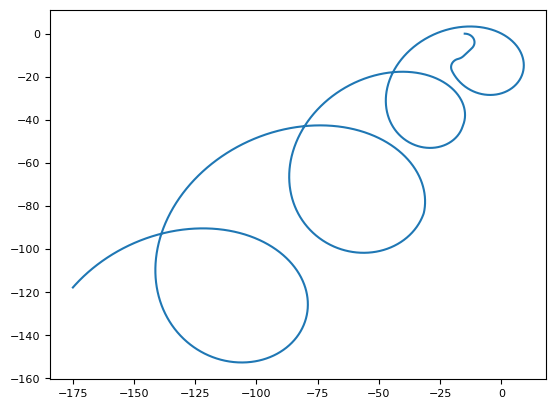

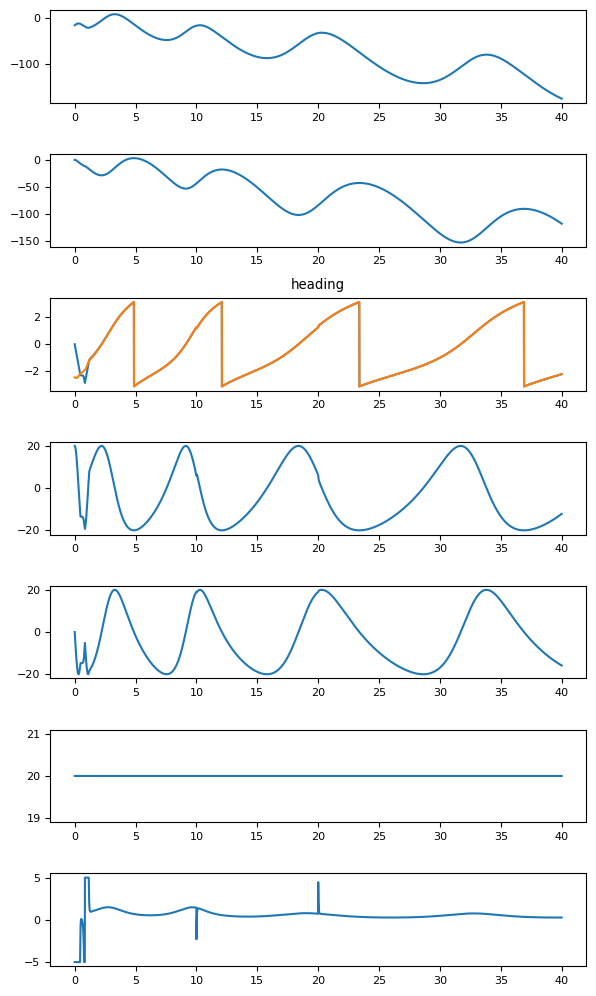

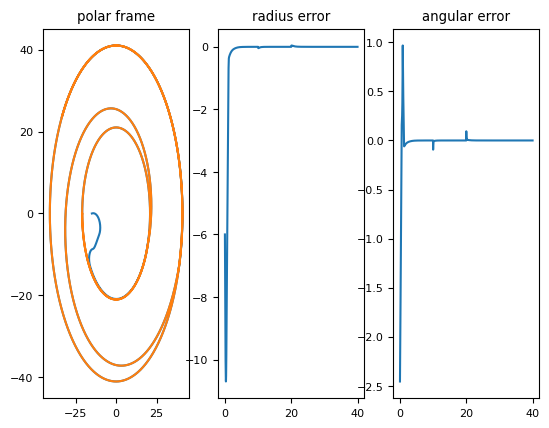

In [ ]:
speed = 20
def radius_f(x, t):
    r = np.zeros_like(t)
    t = np.asarray(t)
    r[t < 10] = 21
    r[(t >= 10) & (t <= 20)] = 21 + 2 * (t[(t >= 10) & (t <= 20)] - 10)
    r[t > 20] = 41
    return r

def radius_dot_f(x, t):
    r = np.zeros_like(t)
    t = np.asarray(t)
    r[t < 10] = 0
    r[(t >= 10) & (t <= 20)] = 2
    r[t >= 20] = 0
    return r

def rk4(sys, t, x, step):
    k1 = sys(t,x)
    k2 = sys(t + step/2, k1/2 * step + x)
    k3 = sys(t + step/2, k2/2 * step + x)
    k4 = sys(t + step, k3 * step + x)
    xn = x + step / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return xn

def angleDiff(a, b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi

k = 40
beta = .5
print(f'k > {2 / np.pi * speed *np.arctan(beta) ** 2}, beta {beta}, k {k}')
DELTA = 1e-6

def sys(t, x):
    xy =  u(x[:2], t)
    theta = np.arctan2(xy[1], xy[0])
    thetaff = psi_dot(x, t)
    theta_diff = angleDiff(theta, x[2])

    dtheta = k * theta_diff + thetaff + invert(x, t)
    dtheta = np.clip(dtheta, -5, 5)
    return np.array([
        speed * np.cos(x[2]),
        speed * np.sin(x[2]),
        dtheta
    ])

class Results:
    def __init__(self, t, y):
        self.t = t
        self.y = y
dt = .01
t0 = 0
tf = 40
t_span = np.arange(t0, tf, dt)
x = [-15, 0, 0]
y = [x]
for t in t_span:
    x = rk4(sys, t, x, dt)
    y.append(x)
res = Results(t_span, np.array(y[:-1]).T)
# res = solve_ivp(sys, [t0, tf], x, max_step=.1)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(res.y[0, :], res.y[1, :])

fig = plt.figure(figsize=(6, 10))
axes = fig.subplots(7)
axes[0].plot(res.t, res.y[0, :])
axes[1].plot(res.t, res.y[1, :])
axes[2].set_title('heading')
axes[2].plot(res.t, (res.y[2, :] + np.pi) % (2 * np.pi) - np.pi)
xy = np.array([u(x, t) for x, t in zip(res.y.T, res.t)])
theta = np.arctan2(xy[:, 1], xy[:, 0])
axes[2].plot(res.t, theta)
dx = np.array([sys(t, x) for t, x in zip(res.t, res.y.T)])
axes[3].plot(res.t, dx[:, 0])
axes[4].plot(res.t, dx[:, 1])
axes[5].plot(res.t, np.linalg.norm(dx[:, :2], axis=1))
axes[6].plot(res.t, dx[:, 2])
fig.tight_layout()

fig = plt.figure()
g = lambda x, t: vel * t
v_loc = np.array([g([0, 0], t) for t in res.t])
dist = res.y[:2] - v_loc.T 
axes = fig.subplots(1, 3)
axes[0].plot(dist[0, :], dist[1, :])
theta = np.arctan2(dist[1, :], dist[0, :])
axes[0].plot(radius_f([0, 0], res.t) * np.cos(theta), radius_f([0, 0], res.t) * np.sin(theta))
axes[0].set_title('polar frame')
axes[1].plot(res.t, (np.linalg.norm(dist, axis=0) - radius_f([0, 0], res.t)))
axes[1].set_title('radius error')
# axes[1].set_ylim([-.1, .1])

xy = np.array([u(x, t) for x, t in zip(res.y.T, res.t)])
theta = np.arctan2(xy[:, 1], xy[:, 0])
axes[2].plot(res.t, angleDiff(theta, res.y[2, :]))
axes[2].set_title('angular error')